In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import time

from IPython.display import Image
import torch
from collections import defaultdict
import imageio
from sradmap import SkyCoord2FisheyeUV, loadConfig
import numpy as np
from tqdm import tqdm

import math

In [2]:
# Not randomizing to make sure the indexes are correct
skies_data = pd.read_csv("..\..\scattered-hdr.csv")

In [3]:
print("Current Directory:")
print(os.path.dirname(os.path.realpath("__file__")))

src_dir = "D:\skies"
print(src_dir)

images_by_size = defaultdict(lambda: [])


def time_to_images(timestamp: str) -> str:
    time_obj = time.strptime(timestamp, "%m/%d/%Y %H:%M:%S")
    date_dir = time.strftime("%Y-%m-%d", time_obj)
    time_dir = time.strftime("%H.%M.%S", time_obj)

    entries = os.scandir("{}\{}\HDR\{}".format(src_dir, date_dir, time_dir))
    jpgs = [
        entry.path
        for entry in entries
        if entry.is_file() and os.path.splitext(entry.name)[-1].lower() == ".jpg"
    ]
    jpgs.sort()

    images_by_size[len(jpgs)].append(jpgs)

    if len(jpgs) < 8:
        raise BaseException("LESS THAN 8 PICTURES skip this sky")

    return jpgs[:8]

Current Directory:
C:\Users\Hernan\Desktop\School\SR\SpectralSkyLearn-master\sradmap
D:\skies


In [4]:
# iter_num = 0
image_paths = []
for index, row in skies_data.iterrows():
    month, day, year = row["Date"].split("/")
    if len(month) < 2:
        month = "0" + month
    if len(day) < 2:
        day = "0" + day

    timestamp = "{}/{}/{} {}".format(month, day, year, row['Time'])

    image_paths.append(time_to_images(timestamp))

    # iter_num += 1
    # if iter_num == 10:
    #    break

dict_keys([8, 9])
5797 images with 9 exposures
example: D:\skies\2012-11-06\HDR\12.32.26\IMG_2649.JPG

10578 images with 8 exposures
example: D:\skies\2013-05-12\HDR\10.30.01\IMG_5048.JPG

For compatibility purposes, all skies have been truncated to only have 8 images

Image example:


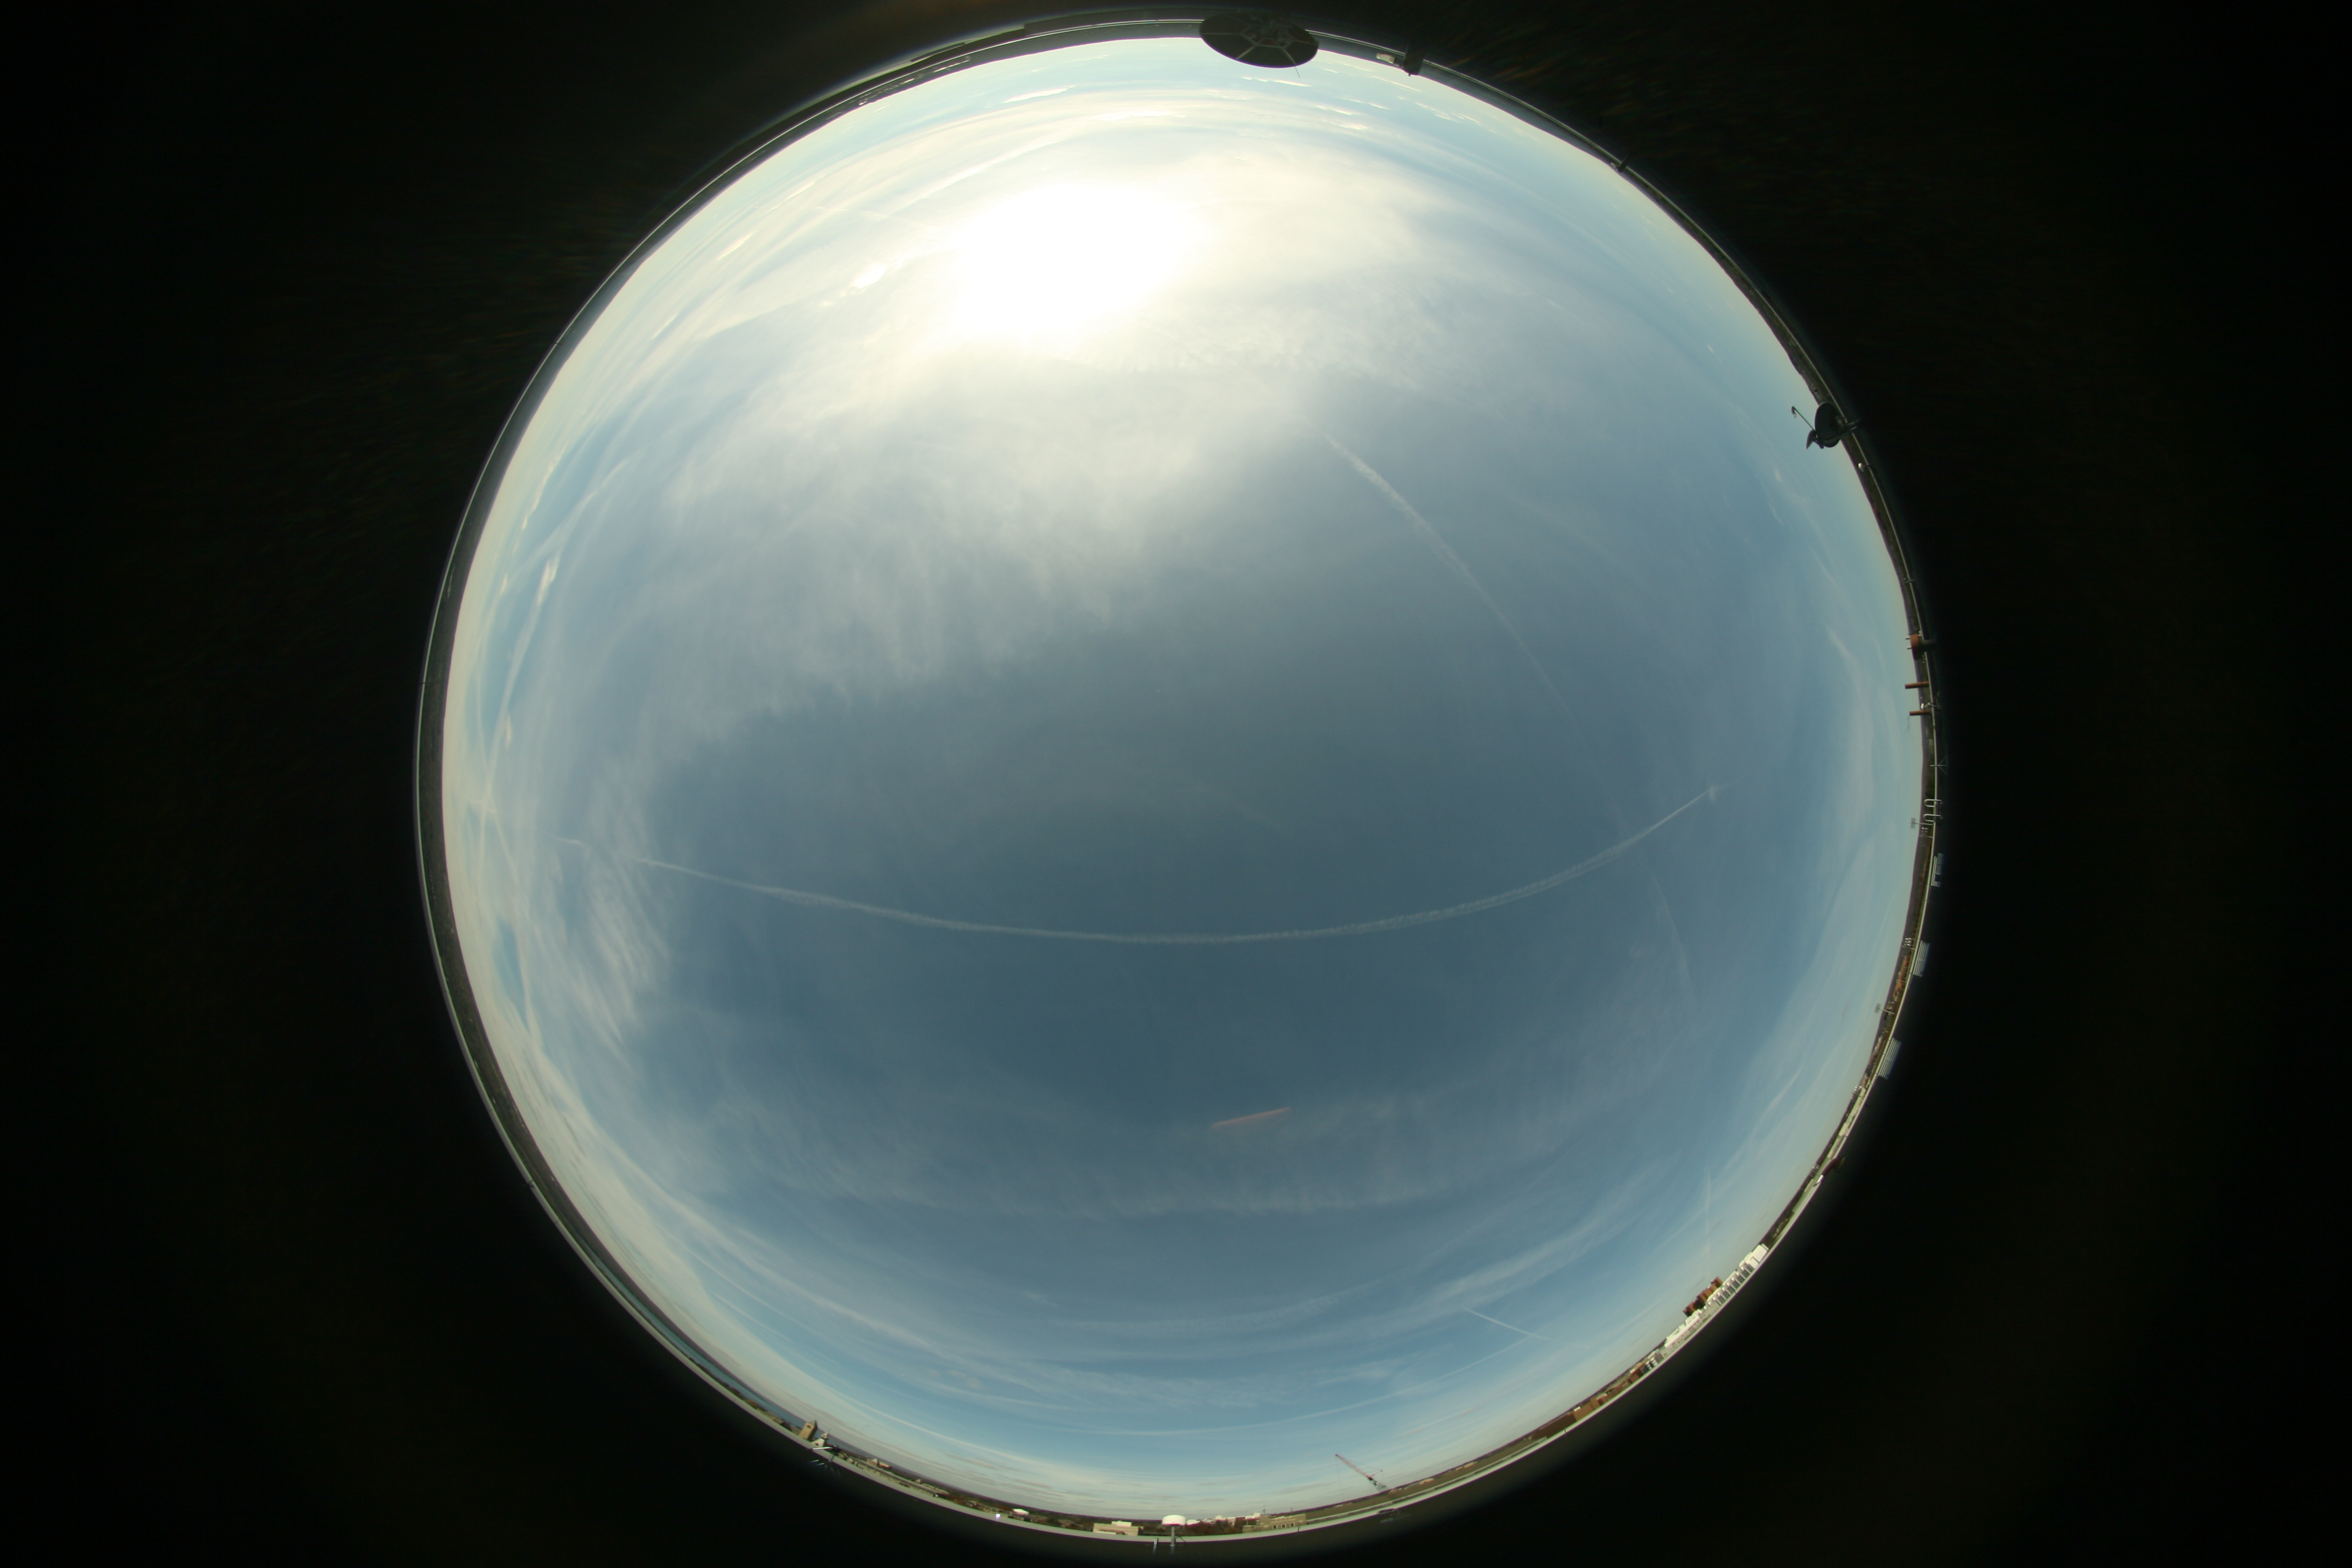

In [5]:
print(images_by_size.keys())
print("{} images with 9 exposures".format(len(images_by_size[9])))
print("example: {}\n".format(images_by_size[9][0][0]))
print("{} images with 8 exposures".format(len(images_by_size[8])))
print("example: {}\n".format(images_by_size[8][0][0]))
print("For compatibility purposes, all skies have been truncated to only have 8 images\n")

print("Image example:")
Image(filename=image_paths[0][6])

In [6]:
azimuth, altitude, date = skies_data[['SampleAzimuth','SampleAltitude', 'Date']].values.tolist()[0]
azimuth, altitude, date, image_paths[0]

(0.0,
 12.1151,
 '11/6/2012',
 ['D:\\skies\\2012-11-06\\HDR\\12.32.26\\IMG_2649.JPG',
  'D:\\skies\\2012-11-06\\HDR\\12.32.26\\IMG_2650.JPG',
  'D:\\skies\\2012-11-06\\HDR\\12.32.26\\IMG_2651.JPG',
  'D:\\skies\\2012-11-06\\HDR\\12.32.26\\IMG_2652.JPG',
  'D:\\skies\\2012-11-06\\HDR\\12.32.26\\IMG_2653.JPG',
  'D:\\skies\\2012-11-06\\HDR\\12.32.26\\IMG_2654.JPG',
  'D:\\skies\\2012-11-06\\HDR\\12.32.26\\IMG_2655.JPG',
  'D:\\skies\\2012-11-06\\HDR\\12.32.26\\IMG_2656.JPG'])

In [7]:
class Args:
    cfgpath = './config.json'
    photo = None
    timestamp = None
    cover = None
    model = None
    scaler = None
    polynomial = None
    colorbar = None

args = Args()
loadConfig(args)
    
def get_samples(images, azimuth, altitude, radius=50):
    image_arrs = torch.from_numpy(
        np.array(
            [imageio.imread(image) for image in images]
        )
    ).permute(0, 3, 1, 2)
    
    channels = int(image_arrs.shape[1])
    height = int(image_arrs.shape[2])
    width = int(image_arrs.shape[3])
    crop_index = int((width - height) / 2)
    image_arrs = image_arrs[:, :, :, crop_index:crop_index + height]
    
    u, v = SkyCoord2FisheyeUV(args, azimuth, altitude)
    x = int(u * height)
    y = int(v * height)

    image_samples = image_arrs[:, :, y-radius:y+radius, x-radius:x+radius]
    for i in range(image_samples.shape[0]):
        for j in range(image_samples.shape[2]):
            for k in range(image_samples.shape[3]):
                y_offset = abs(j - radius)
                x_offset = abs(k - radius)
                if math.hypot(x_offset, y_offset) > radius:
                    image_samples[i, :, j, k] = torch.zeros(channels)
    
    return image_samples

def get_samples_from_df_index(index):
    azimuth, altitude = skies_data[['SampleAzimuth','SampleAltitude']].values.tolist()[index]
    images = image_paths[index]
    return get_samples(images, azimuth, altitude)

def display_image(image_tensor):
    plt.imshow(image_tensor.permute(1, 2, 0).numpy())

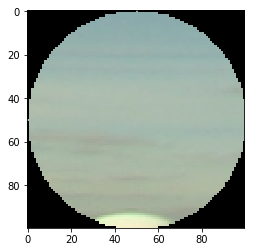

In [8]:
display_image(get_samples_from_df_index(0)[6])

In [9]:
# go to the root of the repo, then create the data folder if it doesn't exist
initial_path = os.path.abspath('')
os.chdir('..')
if not os.path.exists('./data'):
    os.makedirs('./data')
os.chdir('./data')

for index in tqdm(range(skies_data.shape[0])):
    samples = get_samples_from_df_index(index)
    torch.save(samples, str(index))

os.chdir(initial_path)

  0%|▎                                                                           | 74/16375 [01:14<4:34:16,  1.01s/it]


KeyboardInterrupt: 